# Методы обучения без учителя
## Метод главных компонент

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Подготовка данных

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [2]:
# Загружаем данные сенсоров
df_database = pd.read_csv('sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [3]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head(10)

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,...,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,...,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,...,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,...,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,...,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,...,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4
5,-0.107773,-0.127717,-0.028024,0.537501,0.243449,0.505588,0.229391,0.031437,0.0,0.007009,...,0.182925,0.715900,0.710709,0.197230,0.0,0.001413,0.0,0.000000,0,5
6,-0.107148,-0.127270,-0.026863,0.537391,0.242912,0.505869,0.226710,0.023054,0.0,0.007009,...,0.191531,0.671319,0.664602,0.211023,0.0,0.000000,0.0,0.000000,0,6
7,-0.107461,-0.127583,-0.026328,0.538050,0.243132,0.505588,0.222018,0.007813,0.0,0.007009,...,0.191849,0.594949,0.664126,0.235849,0.0,0.000000,0.0,0.000000,0,7
8,-0.109023,-0.128833,-0.025658,0.533924,0.244548,0.504648,0.222018,0.004003,0.0,0.007494,...,0.172939,0.570852,0.708902,0.251297,0.0,0.014764,0.0,0.000000,0,8
9,-0.111077,-0.127672,-0.025568,0.532044,0.244304,0.503879,0.227380,0.016958,0.0,0.007009,...,0.147243,0.665166,0.745378,0.218747,0.0,0.014153,0.0,0.000000,0,9


In [4]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

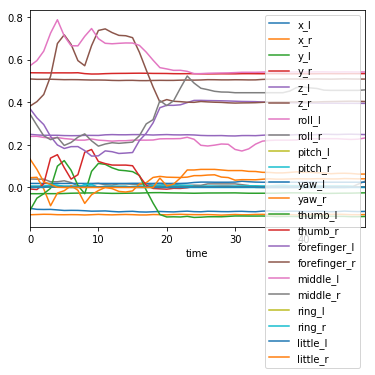

In [5]:
sign0.plot()

In [6]:
df_database.shape

(146949, 24)

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "призаки" для решения задачи классификации.

In [7]:
import sys
sys.executable

'c:\\users\\иван\\appdata\\local\\programs\\python\\python37-32\\python.exe'

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [7]:
## Если не хотите долго ждать - не убирайте комментарии
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# sign_features_filtered = select_features(sign_features, s_classes.loc[:, 'target'])

# filepath = './tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [8]:
filepath = 'tsfresh_features_filt.csv'
sign_features_filtered = pd.read_csv(filepath)

In [9]:
sign_features_filtered.shape

(2565, 10865)

In [10]:
sign_features_filtered.head()

,id,ring_r__maximum,"ring_r__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","ring_r__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","ring_r__fft_coefficient__coeff_2__attr_""abs""","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""",ring_r__standard_deviation,ring_r__variance,...,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,middle_l__symmetry_looking__r_0.35,roll_r__symmetry_looking__r_0.15,roll_r__symmetry_looking__r_0.2,thumb_l__large_standard_deviation__r_0.25,thumb_l__large_standard_deviation__r_0.45,thumb_l__symmetry_looking__r_0.1,thumb_l__symmetry_looking__r_0.4,z_r__symmetry_looking__r_0.35
0,0,0.014764,0.998626,0.000174,0.047854,0.000034,0.006166,0.000423,0.003881,0.000015,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1,1,0.017579,0.017579,0.000180,0.045183,0.000027,0.003599,0.000397,0.003399,0.000012,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,2,0.043917,0.043917,0.000737,0.059952,0.000092,0.028252,0.001034,0.011921,0.000142,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4,4,0.061037,0.061037,0.001453,0.402618,0.000127,0.047034,0.001777,0.017728,0.000314,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


## Базовая модель

В результате у нас получилось очень много признаков (аж 10865), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [12]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

del sign_features_filtered

# классы
enc = LabelEncoder()
enc.fit(sign_classes.loc[:, 'class'])
sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])
y = sign_classes.target.values

In [15]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

C:\Users\Иван\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


MemoryError: 

In [14]:
base_cv_scores.mean()

NameError: name 'base_cv_scores' is not defined

Качество базовой модели должно быть в районе 93.29122%

## Метод главных компонент

* Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`.
* Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%
* К качестве ответа укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Формат ответа: число в интервале [0, 1] c точностью до сотых.

### *РЕШЕНИЕ*

In [20]:
X.shape

(2565, 10865)

In [24]:
pca = PCA(svd_solver="randomized", random_state=123, n_components=5000)
pca.fit(X)

MemoryError: 

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

X = StandardScaler().fit_transform(X)

pca = PCA(n_components=27, svd_solver='randomized', random_state=123)
pca.fit(X)
expl = pca.explained_variance_ratio_.sum()

In [1]:
expl = 0.48294165860716426

# Ответ

In [2]:
print('{:.2f}'.format(expl))

0.48
